# **1. Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Install and Import necessary libraries**

In [ ]:
!pip install astropy pytorch-msssim

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorch_msssim import ms_ssim
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Use %env to set environment variables in Colab
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8


# **3. Dataset Class**

In [ ]:
class ProtoplanetaryDataset(Dataset):
    """
    Loads .fits files from 'data_dir', optionally normalizes each image to [0,1],
    and returns a torch tensor of shape (1,H,W).
    """
    def __init__(self, data_dir, transform=None, normalize=True):
        super().__init__()
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.fits')]
        self.transform = transform
        self.normalize = normalize
        print(f"Found {len(self.files)} .fits files in {data_dir}.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        with fits.open(file_path) as hdul:
            data = hdul[0].data

        # Attempt a slice
        if data.ndim == 5:
            # shape (N,1,1,H,W)
            image = data[0, 0, 0, :, :]
        elif data.ndim == 3:
            image = data[0]
        else:
            image = data

        image = np.array(image, dtype=np.float32)
        image = np.nan_to_num(image, nan=0.0)

        if self.normalize:
            # min-max to [0,1]
            minv, maxv = image.min(), image.max()
            if maxv > minv:
                image = (image - minv) / (maxv - minv)

        # Expand dims -> (1,H,W)
        image = np.expand_dims(image, axis=0)
        tensor_img = torch.from_numpy(image)

        # Apply optional transforms
        if self.transform:
            tensor_img = self.transform(tensor_img)

        return tensor_img

# **4. Data Loader**

In [ ]:
data_path = "/content/drive/My Drive/continuum_data_subset"
crop_size = 256
transform = transforms.Compose([
    # Crop to 256x256
    transforms.Lambda(lambda x: x[:, :crop_size, :crop_size])
])
dataset = ProtoplanetaryDataset(data_path, transform=transform, normalize=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

print(f"Dataset size: {len(dataset)}")

Found 150 .fits files in /content/drive/My Drive/continuum_data_subset.
Dataset size: 150


# **5. Defining the AutoEncoder**

In [ ]:
class ConvAutoencoder(nn.Module):
    """
    Basic autoencoder with a modest latent space.
    .encode() and .decode() accessible for the user.
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (B,16,128,128)
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (B,32,64,64)
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # (B,64,32,32)
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(64*32*32, latent_dim)
        )
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 64*32*32)
        self.decoder_conv = nn.Sequential(
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(64, 32, 32)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # (B,32,64,64)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (B,16,128,128)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # (B,1,256,256)
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        x = self.decoder_fc(z)
        return self.decoder_conv(x)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

# Instantiate
autoencoder = ConvAutoencoder(latent_dim=64).to(device)

# **6. Training Setup**

In [ ]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
criterion_mse = nn.MSELoss()

def train_one_epoch(dataloader, model, optimizer):
    model.train()
    epoch_mse = 0.0
    epoch_ssim = 0.0
    total = 0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()

        outputs = model(batch)

        # MSE
        mse_loss = criterion_mse(outputs, batch)
        # MS-SSIM
        ssim_val = ms_ssim(outputs, batch, data_range=1.0)

        loss = mse_loss

        loss.backward()
        optimizer.step()

        epoch_mse += mse_loss.item() * batch.size(0)
        epoch_ssim += ssim_val.item() * batch.size(0)
        total += batch.size(0)

    return epoch_mse/total, epoch_ssim/total

# **7. Training Loop**

In [ ]:
num_epochs = 30
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

mse_list = []
ssim_list = []

for epoch in range(num_epochs):
    mse, ssim = train_one_epoch(dataloader, autoencoder, optimizer)

    mse_list.append(mse)
    ssim_list.append(ssim)

    print(f"Epoch [{epoch+1}/{num_epochs}] - MSE: {mse:.6f}, MS-SSIM: {ssim:.6f}")

Epoch [1/30] - MSE: 0.000349, MS-SSIM: 0.967766
Epoch [2/30] - MSE: 0.000332, MS-SSIM: 0.968762
Epoch [3/30] - MSE: 0.000316, MS-SSIM: 0.969757
Epoch [4/30] - MSE: 0.000300, MS-SSIM: 0.970598
Epoch [5/30] - MSE: 0.000285, MS-SSIM: 0.971450
Epoch [6/30] - MSE: 0.000271, MS-SSIM: 0.972359
Epoch [7/30] - MSE: 0.000257, MS-SSIM: 0.973234
Epoch [8/30] - MSE: 0.000247, MS-SSIM: 0.974202
Epoch [9/30] - MSE: 0.000240, MS-SSIM: 0.975020
Epoch [10/30] - MSE: 0.000236, MS-SSIM: 0.975723
Epoch [11/30] - MSE: 0.000232, MS-SSIM: 0.976344
Epoch [12/30] - MSE: 0.000228, MS-SSIM: 0.976858
Epoch [13/30] - MSE: 0.000228, MS-SSIM: 0.976803
Epoch [14/30] - MSE: 0.000222, MS-SSIM: 0.977229
Epoch [15/30] - MSE: 0.000222, MS-SSIM: 0.977436
Epoch [16/30] - MSE: 0.000224, MS-SSIM: 0.977228
Epoch [17/30] - MSE: 0.000214, MS-SSIM: 0.977769
Epoch [18/30] - MSE: 0.000212, MS-SSIM: 0.978826
Epoch [19/30] - MSE: 0.000210, MS-SSIM: 0.978799
Epoch [20/30] - MSE: 0.000207, MS-SSIM: 0.979367
Epoch [21/30] - MSE: 0.000205

In [ ]:
# Save the model
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

# **8. Visualization**

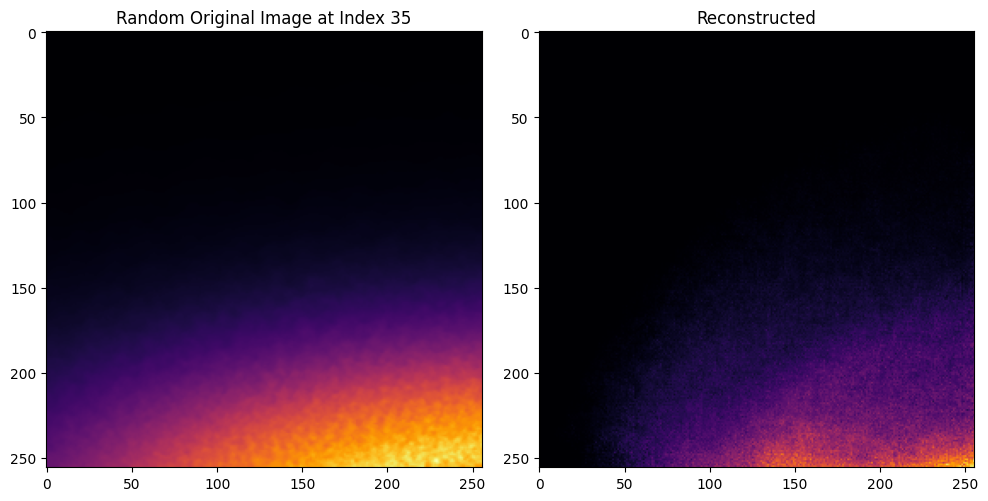

In [ ]:
# Get a random index from the dataset
i = random.randint(0, len(dataset) - 1)
image = dataset[i].unsqueeze(0).to(device)

# Run inference
autoencoder.eval()
with torch.no_grad():
    recon = autoencoder(image)

# Convert to numpy
image = image.cpu().numpy()
recon = recon.cpu().numpy()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(image[0, 0], cmap='inferno')
axs[0].set_title(f"Random Original Image at Index {i}")
axs[1].imshow(recon[0, 0], cmap='inferno')
axs[1].set_title("Reconstructed")
plt.tight_layout()
plt.show()

# **9. Access Latent Space**

In [ ]:
# Choose a random index from the dataset
rand_idx = random.randint(0, len(dataset) - 1)
random_image = dataset[rand_idx].unsqueeze(0).to(device)  # Add batch dimension

# Encode and view latent vector
with torch.no_grad():
    latent_vec = autoencoder.encode(random_image)

print("Latent vector:", latent_vec.cpu().numpy().flatten()[:10])


Latent vector: [ 22.754887 -24.87884   26.277723 -40.616505 -25.836086  22.313023
 -21.501749  29.654217 -38.54662   16.709845]


====# **10. Save All of the reconstructed images to Google Drive**

In [ ]:
import os
import matplotlib.pyplot as plt

# 1) Create a folder in your Drive for comparison images
compare_dir = "/content/drive/My Drive/reconstructed_images"
os.makedirs(compare_dir, exist_ok=True)

# 2) Make a non-shuffled DataLoader for systematic inference
dataloader_infer = DataLoader(dataset, batch_size=4, shuffle=False)

autoencoder.eval()

img_index = 0
with torch.no_grad():
    for batch in dataloader_infer:
        # Move batch to GPU/CPU
        batch = batch.to(device)
        # Get reconstructions
        recon = autoencoder(batch)

        # Loop over images in the batch
        for i in range(batch.size(0)):
            # Convert original + reconstructed to numpy (shape [H, W])
            orig_np = batch[i].cpu().numpy()[0]
            recon_np = recon[i].cpu().numpy()[0]

            # Plot side-by-side
            fig, axes = plt.subplots(1, 2, figsize=(8,4))
            axes[0].imshow(orig_np, cmap='inferno')
            axes[0].set_title("Original")
            axes[0].axis('off')

            axes[1].imshow(recon_np, cmap='inferno')
            axes[1].set_title("Reconstructed")
            axes[1].axis('off')

            # Save the figure
            out_fname = f"comparison_{img_index}.png"
            out_path = os.path.join(compare_dir, out_fname)
            plt.savefig(out_path, bbox_inches='tight')
            plt.close(fig)

            img_index += 1
print(f"Side-by-side comparisons saved to: {compare_dir}")

Side-by-side comparisons saved to: /content/drive/My Drive/reconstructed_images


In [ ]:
# Re-import model class (make sure Autoencoder class is defined)
model = ConvAutoencoder().to(device)

# Load saved weights
model.load_state_dict(torch.load('autoencoder.pth'))

# Set to evaluation mode
model.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=64, bias=True)
  )
  (decoder_fc): Linear(in_features=64, out_features=65536, bias=True)
  (decoder_conv): Sequential(
    (0): ReLU(inplace=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 32, 32))
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), out

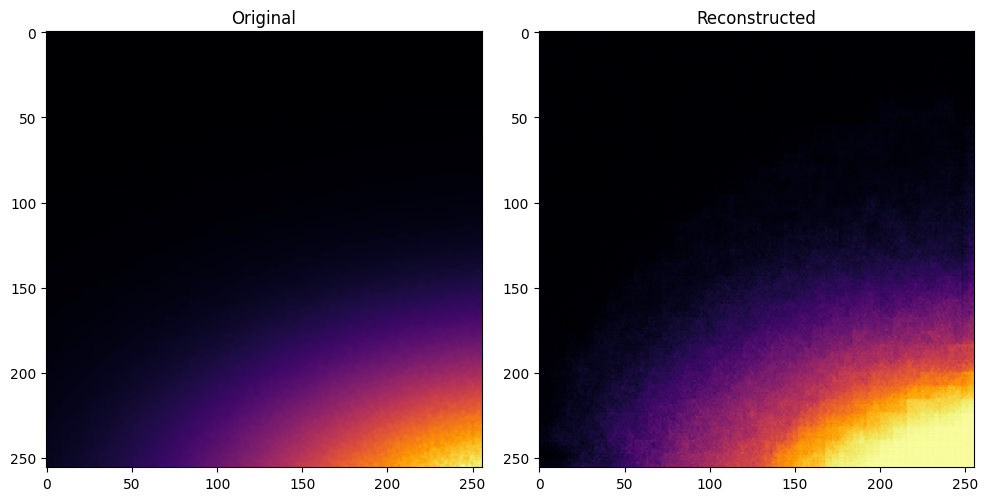

In [ ]:
# Get a random image from dataset
import random
idx = random.randint(0, len(dataset) - 1)
image = dataset[idx].unsqueeze(0).to(device)  # Add batch dimension

# Inference
with torch.no_grad():
    reconstructed = model(image)

# Visualize
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image.squeeze().cpu(), cmap='inferno')
axs[0].set_title("Original")

axs[1].imshow(reconstructed.squeeze().cpu(), cmap='inferno')
axs[1].set_title("Reconstructed")

plt.tight_layout()
plt.show()
